In [3]:
from prov.model import *
import prov.model as prov
from http import cookies
import sqlite3 as lite
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
from prov.dot import prov_to_dot
from IPython.display import Image

class ProvManager():
    def __init__(self, output_fp=path.join(os.getcwd(), "results/"), db_fp="/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/crawl-data.sqlite"):
        self.db_fp = db_fp
        self.output_fp = output_fp
        self.documents = {}
        self.all_tp_hosts = {1: [],
                           2: [],
                           3: [],
                           4: []}
        self.cur = None
        if not path.exists(self.output_fp):
            os.mkdir(self.output_fp)
            
#     if __main__ == "main":
#         main()
        
    def main(self):
        self.db_connect()
        self.create_prov()
        self.record_prov()
        self.write_prov()
        self.all_cookie_stats()
    
    def db_connect(self):
        connection = lite.connect(self.db_fp)
        self.cur = connection.cursor()
    
    def create_prov(self):
        for visit_id in self.cur.execute("select visit_id from site_visits"):
            document = ProvDocument()
            document.set_default_namespace('http://danik.com')
            self.documents[visit_id[0]] = document
#         return document
    
    def retrieve_tp_hosts(self,visit_id, site_url):
        hosts = []
        for h in self.cur.execute("select host from javascript_cookies where visit_id=?", str(visit_id)):
            split = h[0].split('.')
            if 'www' in split: split.remove('www')
            host = split[1]
            for el in split[2:]:
                host += "." + el
            if site_url.find(host) == -1:
                hosts.append(h[0])
        return hosts
    
    def record_prov(self):        
        for visit, doc in self.documents.items():
            tp_hosts = []
            doc.agent('OpenWPM', {'prov:type': 'prov:SoftwareAgent'})
            doc.agent('user')
            doc.activity('performCrawl')
            doc.entity('visit%d'%visit)
            self.cur.execute("select site_url from site_visits where visit_id=?",str(visit))
            site_url = self.cur.fetchone()[0][7:]
            doc.entity(site_url)
            doc.entity('syncing_algorithm')
            doc.agent('tracker1')
            doc.agent('tracker2')
            doc.activity('syncCookies')
            doc.activity('collectData')

            tp_cookies = doc.collection('cookies%d'%visit)
        #     tp_cookies.set_default_namespace('http://danik.com/bundles')
#             sync_algorithm = doc.bundle('syncing_algorithm')
        #     sync_algorithm.set_default_namespace('http://danik.com/syncing')


            doc.actedOnBehalfOf('OpenWPM', 'user')
            doc.wasAssociatedWith('performCrawl', 'OpenWPM')
            doc.wasGeneratedBy('visit%d'%visit, 'performCrawl')
            doc.wasDerivedFrom('visit%d'%visit, site_url, 'performCrawl')
            doc.wasAttributedTo(site_url, 'tracker1')
            doc.wasAssociatedWith('collectData', 'tracker1')
            doc.wasGeneratedBy('cookies%d'%visit, 'collectData')
            doc.actedOnBehalfOf('tracker2', 'tracker1', 'syncCookies')
            doc.used('syncCookies', 'cookies%d'%visit)
            doc.used('syncCookies', 'syncing_algorithm')
            doc.used('performCrawl', site_url)
            doc.used('collectData', site_url)

#             for h in cur.execute("select host from javascript_cookies where visit_id=?", str(visit)):
#                 split = h[0].split('.')
#                 if 'www' in split: split.remove('www')
#                 host = split[1]
#                 for el in split[2:]:
#                     host += "." + el
#                 if site_url.find(host) == -1:
#                     tp_hosts.append(h[0])
            tp_hosts = self.retrieve_tp_hosts(visit, site_url)
#             print(tp_hosts)
        #         hosts.append(host)
        #         if host in trackers:
        #             hosts.append(host)
            for tp in tp_hosts:
                e = doc.entity(tp)
                doc.hadMember(tp_cookies, e)
            self.all_tp_hosts[visit] = tp_hosts
        print("finished record:")
        print(self.all_tp_hosts[2])
            
    def write_prov(self):
        for visit, document in self.documents.items():
            dot = prov_to_dot(document)
            dot.write_png(path.join(self.output_fp,'visit%d.png' %visit))
#             file = open(path.join(self.output_fp,'visit%d.png' %visit), 'w+')
#             file.write(dot)
#             file.close()
            print("writing")
#             dot.write_png('visit%d.png' %visit)

    def cookie_stats(self, visit_id, site_url = ""):
        tp_cookies = self.all_tp_hosts[visit_id]
        self.cur.execute("select count(id) from javascript_cookies where visit_id=?", str(visit_id))
        cookies_num = self.cur.fetchone()[0]
        print("This visit resulted in %d cookies being recorded on your browser." % cookies_num)
        if len(tp_cookies) == 0:
            print("None of which are 3rd party")
        else:
            print("Of which %d are 3rd party."%len(tp_cookies))
            print("List of 3rd party trackers: ")
            print(set(tp_cookies))
            self.cookie_pie(cookies_num, len(tp_cookies), site_url)
            
    def all_cookie_stats(self,):
        for vid, cs in self.all_tp_hosts.items():
            self.cur.execute("select site_url from site_visits where visit_id=?",str(vid)) #TODO: Refactor this
            site_url = self.cur.fetchone()[0][7:]
            print("\nVisit %d to %s" % (vid, site_url), end='')
            self.cookie_stats(vid, site_url = site_url)
            
    def cookie_pie(self, num_total, num_tp, site_url=""):
        color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', 
                              '#C1F0F6', '#0099CC']
        labels = ['1st Party', '3rd Party']
        plt.rcParams['font.sans-serif'] = 'Arial'
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['text.color'] = '#e8001b'
        plt.rcParams['axes.labelcolor']= '#e8001b'
        plt.rcParams['xtick.color'] = '#e8001b'
        plt.rcParams['ytick.color'] = '#e8001b'
        plt.rcParams['font.size']=12
        values = [num_total -num_tp, num_tp]
        explode = (0.1, 0)

        fig, ax = plt.subplots()
        ax.pie(values, labels=labels, explode=explode, colors=color_palette_list[0:2], autopct='%1.0f%%', shadow=False, startangle=90, pctdistance=0.8, labeldistance=1.1)
        ax.axis('equal')
        ax.set_title('Proportion of 3rd party cookies from %s\nTotal number of cookies: %d' %(site_url, num_total))
        ax.legend(frameon=False, bbox_to_anchor=(1.5, 0.8))

In [3]:
string = "12:40:53"
string[:-3:]

'12:40'

/Users/Danik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


Text(0.5, 1.0, 'Easy as 1, 2, 3')

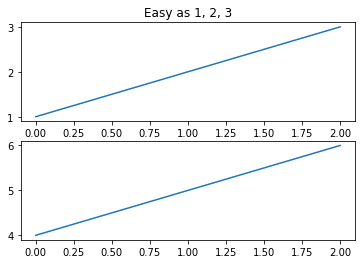

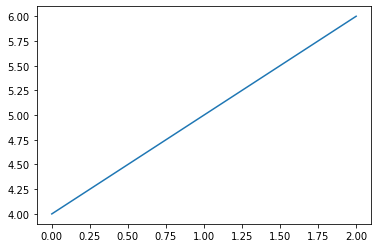

In [10]:
import matplotlib.pyplot as plt
plt.figure(1)                # the first figure
plt.subplot(211)             # the first subplot in the first figure
plt.plot([1, 2, 3])
plt.subplot(212)             # the second subplot in the first figure
plt.plot([4, 5, 6])


plt.figure(2)                # a second figure
plt.plot([4, 5, 6])          # creates a subplot(111) by default

plt.figure(1)                # figure 1 current; subplot(212) still current
plt.subplot(211)             # make subplot(211) in figure1 current
plt.title('Easy as 1, 2, 3') # subplot 211 title


In [4]:
doc = ProvDocument()
doc.set_default_namespace('http://danik.com')

In [7]:
doc.agent('OpenWPM', {'prov:type': 'prov:SoftwareAgent'})
doc.agent('user')
doc.activity('performCrawl')
doc.entity('visit2')
doc.entity('kcl.ac.uk')
doc.entity('syncing_algorithm')
doc.agent('tracker1')
doc.agent('tracker2')
doc.activity('syncCookies')
doc.activity('collectData')
doc.actedOnBehalfOf('OpenWPM', 'user')
doc.wasAssociatedWith('performCrawl', 'OpenWPM')
doc.wasGeneratedBy('visit2', 'performCrawl')
doc.wasDerivedFrom('visit2', 'kcl.ac.uk', 'performCrawl')
doc.wasAttributedTo('kcl.ac.uk', 'tracker1')
doc.wasAssociatedWith('collectData', 'tracker1')
doc.wasGeneratedBy('cookies2', 'collectData')
doc.actedOnBehalfOf('tracker2', 'tracker1', 'syncCookies')
doc.used('syncCookies', 'cookies2')
doc.used('syncCookies', 'syncing_algorithm')
doc.used('performCrawl', 'kcl.ac.uk')
doc.used('collectData', 'kcl.ac.uk')

<ProvUsage: (collectData, kcl.ac.uk)>

In [10]:
doc.serialize('testdoc.json', indent=2)

In [46]:
json_2 = doc.serialize(indent=2)
json_4 = doc.serialize(indent=4)

In [36]:
import json


In [38]:
pyjs = json.loads(js)

In [51]:
con = lite.connect("/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/crawl-data.sqlite")
cur = con.cursor()

In [63]:
for crawl in cur.execute("select crawl_id from crawl"):
    print(crawl[0])
    cursor2 = lite.connect("/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/crawl-data.sqlite").cursor()
    cursor2.execute("select crawl_id from crawl where task_id=1")
    print(cursor2.fetchone()[0])

1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1


In [71]:
crawl_fp = os.path.join("/Users/Danik/Desktop/KCL/YEAR_3/PRJ/", "Crawls", "Results", "crawl%d"%2)

In [73]:
os.path.isdir(crawl_fp)

True

In [330]:
crawls = [1,2,3,4,5,6,7,8,9,10,11,12,13]
# visits = {cr:{} for cr in crawls}
print(visits)

{1: {1: None, 2: None, 3: None}, 2: {4: None, 5: None}, 3: {6: None, 7: None}, 4: {8: None, 9: None}, 5: {10: None}, 6: {11: None, 12: None}, 7: {13: None, 14: None}, 8: {15: None, 16: None}, 9: {17: None}, 10: {18: None}, 11: {19: None}, 12: {20: None}, 13: {21: None}}


In [317]:
for crawl in crawls:
#     print(crawl)
    for sv in cur.execute("select visit_id from site_visits where crawl_id=?",[str(crawl)]):
    #     print(cid, visits[cid])
    #     print(cid)
#         print(sv[0])
        visits[crawl][sv[0]] = None
print(visits)

{1: {1: None, 2: None, 3: None}, 2: {4: None, 5: None}, 3: {6: None, 7: None}, 4: {8: None, 9: None}, 5: {10: None}, 6: {11: None, 12: None}, 7: {13: None, 14: None}, 8: {15: None, 16: None}, 9: {17: None}, 10: {18: None}, 11: {19: None}, 12: {20: None}, 13: {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: None, 15: None, 16: None, 17: None, 18: None, 19: None, 20: None, 21: None}}


In [331]:
for crawl in crawls:
     visits[crawl] = {sv[0]: None for sv in cur.execute("select visit_id from site_visits where crawl_id=?",[str(crawl)])}
print(visits)

{1: {1: None, 2: None, 3: None}, 2: {4: None, 5: None}, 3: {6: None, 7: None}, 4: {8: None, 9: None}, 5: {10: None}, 6: {11: None, 12: None}, 7: {13: None, 14: None}, 8: {15: None, 16: None}, 9: {17: None}, 10: {18: None}, 11: {19: None}, 12: {20: None}, 13: {21: None}}


In [249]:
json_fp = path.join(crawl_fp,"json")
print(json_fp)

/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/Results/crawl2/json


In [204]:
print(visits[2])
for file, visit in zip(os.listdir(json_fp), visits[2]):
    visits[2].append((visit,file))
    
#     print(visit)
print(visits[2])
p

[4, 5]
[4, 5, (4, 'visit4.json'), (5, 'visit5.json')]


In [288]:
vis_from = visits[2]
vis_from

[{4: None}, {5: None}]

In [291]:
for visit in vis_from:
    vid = list(visit.keys())[0]
#     print(visit[vid])
    visit[vid] =  "hi"
vis_from

[{4: 'hi'}, {5: 'hi'}]

In [295]:
visits[2]

[{4: 'hi'}, {5: 'hi'}]

In [254]:
for file in os.listdir("/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/Results/crawl2/json"):
    file_fp = path.realpath(file)
print(file_fp)

/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Notebooks/visit5.json


In [362]:
with open("/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/Results/crawl9/json/visit17.json", 'r') as js:
    ja = json.load(js)

In [358]:
visits[2]

{4: 'hi', 5: 'hi'}

In [364]:
try:
    for cook, v in ja['hadMember'].items():
    #     cook[0]
    #     print(cook, v)
        print(v['prov:entity'])
except:
    print("No hosts!")

No hosts!
